torch.Size([5000, 60]) torch.Size([5000, 60])
torch.Size([5000, 60])


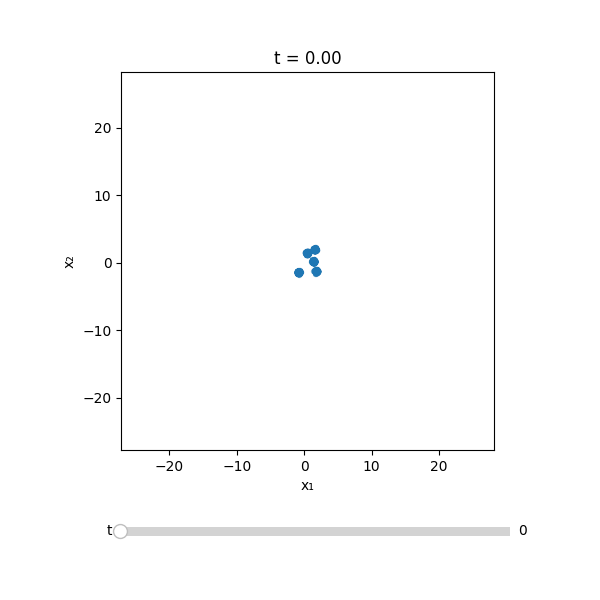

: 

In [ ]:
%matplotlib widget

import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import torch.distributions as D
from kac_utils_radial import create_sk

# ------------------------------------
# Parameters
dim, traj_count = 2, 5000
c, a, T = 5.0, 1.0, 5.0

device = 'mps'#torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ------------------------------------
# Sample GMM initial points
mix  = D.Categorical(torch.ones(5, device=device) / 5)
comp = D.Independent(
    D.Normal(torch.rand(5, dim, device=device) * 4 - 2, 0.1),
    1
)
gmm = D.MixtureSameFamily(mix, comp)
x0  = gmm.sample((traj_count,))  # shape (traj_count, dim)

# Precompute Kac segment times at T
t_full = torch.full((traj_count,), T, device=device)
s_k, cums = create_sk(a, t_full, T)
s_k, cums = s_k.to(device), cums.to(device)
print(s_k.shape, cums.shape)

# ------------------------------------
# Function to compute multi-directional x_t
def compute_pos_multi(x0_batch, t_val):
    B = x0_batch.shape[0]
    t_vec = torch.full((B,), t_val, device=device)
    mask = cums < t_vec.unsqueeze(1)         # (B, J)
    n_jumps = mask.sum(dim=1)               # (B,)
    durations = s_k * mask.float()          # (B, J)
    print(durations.shape)
    prev_idx = (n_jumps - 1).clamp(min=0)
    prev_cum = cums.gather(1, prev_idx.unsqueeze(1)).squeeze(1)
    prev_cum[n_jumps == 0] = 0.0
    partial = (t_vec - prev_cum).clamp(min=0)
    durations.scatter_(1, n_jumps.unsqueeze(1), partial.unsqueeze(1))
    B, J = durations.shape

    u_k = torch.randn(B, J, dim, device=device)
    u_k = u_k / u_k.norm(dim=2, keepdim=True)
    disp = (durations.unsqueeze(2) * u_k).sum(dim=1)  # (B, dim)
    return x0_batch + c * disp

# Initial positions at t=0
pos0 = compute_pos_multi(x0, 0.0).cpu()

# ------------------------------------
# Plot setup
fig, ax = plt.subplots(figsize=(6,6))
plt.subplots_adjust(bottom=0.25)
scatter = ax.scatter(pos0[:,0], pos0[:,1], s=8, alpha=0.5)
ax.set_aspect('equal')
margin = c * T + 1.0
ax.set_xlim(pos0[:,0].min()-margin, pos0[:,0].max()+margin)
ax.set_ylim(pos0[:,1].min()-margin, pos0[:,1].max()+margin)
ax.set_xlabel('x₁'); ax.set_ylabel('x₂')
ax.set_title(f"t = 0.00")

# ------------------------------------
# Slider
ax_slider = plt.axes([0.2, 0.1, 0.65, 0.03])
slider = Slider(ax_slider, 't', 0.0, T, valinit=0.0)

def update(val):
    t_now = slider.val
    pos = compute_pos_multi(x0, t_now).cpu()
    scatter.set_offsets(pos[:, :2].numpy())
    ax.set_title(f"t = {t_now:.2f}")
    fig.canvas.draw_idle()

slider.on_changed(update)
plt.show()


torch.Size([5000, 100])


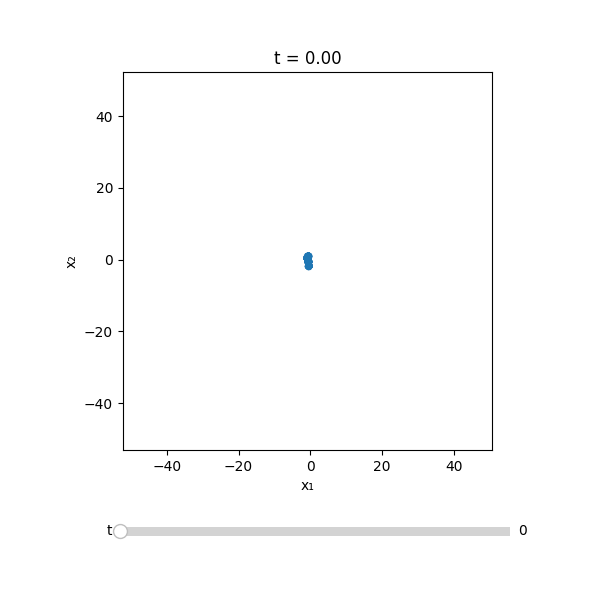

In [126]:
%matplotlib widget

import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import torch.distributions as D
from kac_utils_radial import create_sk

# ------------------------------------
# Parameters
dim, traj_count = 100, 5000
c, a, T = 100.0, 10.0, 10.0

device = 'mps'#torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ------------------------------------
# Sample GMM initial points
mix  = D.Categorical(torch.ones(5, device=device) / 5)
comp = D.Independent(
    D.Normal(torch.rand(5, dim, device=device) * 4 - 2, 0.1),
    1
)
gmm = D.MixtureSameFamily(mix, comp)
x0  = gmm.sample((traj_count,))  # shape (traj_count, dim)

# Precompute Kac segment times at T
t_full = torch.full((traj_count,), T, device=device)
s_k, cums = create_sk(a, t_full, T)
s_k, cums = s_k.to(device), cums.to(device)

# ------------------------------------
# Function to compute multi-directional x_t
def compute_pos_multi(x0_batch, t_val):
    B = x0_batch.shape[0]
    t_vec = torch.full((B,), t_val, device=device)
    mask = cums < t_vec.unsqueeze(1)         # (B, J)
    n_jumps = mask.sum(dim=1)               # (B,)
    durations = s_k * mask.float()          # (B, J)
    prev_idx = (n_jumps - 1).clamp(min=0)
    prev_cum = cums.gather(1, prev_idx.unsqueeze(1)).squeeze(1)
    prev_cum[n_jumps == 0] = 0.0
    partial = (t_vec - prev_cum).clamp(min=0)
    durations.scatter_(1, n_jumps.unsqueeze(1), partial.unsqueeze(1))
    B, J = durations.shape
    u_k = torch.randn(B, J, dim, device=device)
    u_k = u_k / u_k.norm(dim=2, keepdim=True)
    disp = (durations.unsqueeze(2) * u_k).sum(dim=1)  # (B, dim)
    return x0_batch + c * disp

# Initial positions at t=0
pos0 = compute_pos_multi(x0, 0.0).cpu()

# ------------------------------------
# Plot setup
fig, ax = plt.subplots(figsize=(6,6))
plt.subplots_adjust(bottom=0.25)
scatter = ax.scatter(pos0[:,0], pos0[:,1], s=8, alpha=0.5)
ax.set_aspect('equal')
margin = c * T / 20 + 1.0
print(pos0.shape)
ax.set_xlim(pos0[:,0].min()-margin, pos0[:,0].max()+margin)
ax.set_ylim(pos0[:,1].min()-margin, pos0[:,1].max()+margin)
ax.set_xlabel('x₁'); ax.set_ylabel('x₂')
ax.set_title(f"t = 0.00")

# ------------------------------------
# Slider
ax_slider = plt.axes([0.2, 0.1, 0.65, 0.03])
slider = Slider(ax_slider, 't', 0.0, T, valinit=0.0)

def update(val):
    t_now = slider.val
    pos = compute_pos_multi(x0, t_now).cpu()
    scatter.set_offsets(pos[:, :2].numpy())
    ax.set_title(f"t = {t_now:.2f}")
    fig.canvas.draw_idle()

slider.on_changed(update)
plt.show()


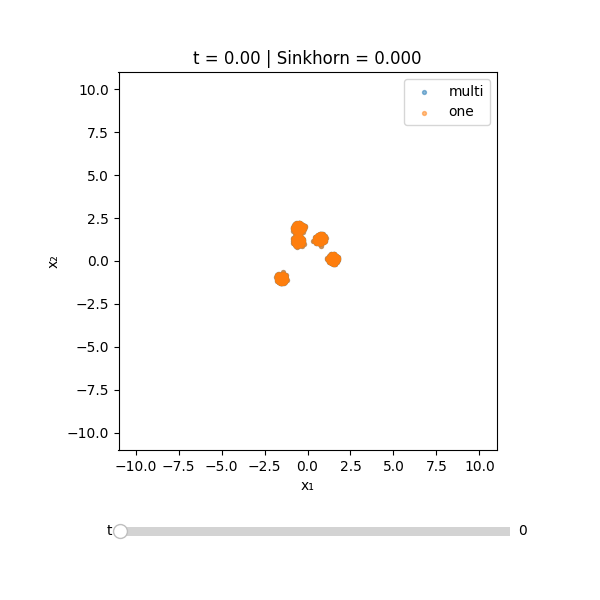

In [6]:
%matplotlib widget

import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import torch.distributions as D
from geomloss import SamplesLoss
from kac_utils_radial import create_sk, sample_trj

# ------------------------------------
# Parameters
dim, traj_count = 2, 5000   # reduce count for Sinkhorn speed
c, a, T = 10.0, 1.0, 1.0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ------------------------------------
# Prepare Sinkhorn loss
loss_fn = SamplesLoss("energy", p=2, blur=0.2, debias=True)

# ------------------------------------
# Sample GMM initial points
mix  = D.Categorical(torch.ones(5, device=device) / 5)
comp = D.Independent(
    D.Normal(torch.rand(5, dim, device=device) * 4 - 2, 0.1),
    1
)
gmm = D.MixtureSameFamily(mix, comp)
x0  = gmm.sample((traj_count,))  # (traj_count, dim)

# Precompute one-direction random unit vectors
u_one = torch.randn(traj_count, dim, device=device)
u_one = u_one / u_one.norm(dim=1, keepdim=True)

# Precompute Kac segment times at T for multi-directional
t_full = torch.full((traj_count,), T, device=device)
s_k, cums = create_sk(a, t_full, T)
s_k, cums = s_k.to(device), cums.to(device)

# ------------------------------------
# Function to compute multi-directional x_t
def compute_pos_multi(x0_batch, t_val):
    B = x0_batch.shape[0]
    t_vec = torch.full((B,), t_val, device=device)
    mask = cums < t_vec.unsqueeze(1)         # (B, J)
    n_jumps = mask.sum(dim=1)               # (B,)
    durations = s_k * mask.float()          # (B, J)
    prev_idx = (n_jumps - 1).clamp(min=0)
    prev_cum = cums.gather(1, prev_idx.unsqueeze(1)).squeeze(1)
    prev_cum[n_jumps == 0] = 0.0
    partial = (t_vec - prev_cum).clamp(min=0)
    durations.scatter_(1, n_jumps.unsqueeze(1), partial.unsqueeze(1))
    B, J = durations.shape
    u_k = torch.randn(B, J, dim, device=device)
    u_k = u_k / u_k.norm(dim=2, keepdim=True)
    disp = (durations.unsqueeze(2) * u_k).sum(dim=1)  # (B, dim)
    return x0_batch + c * disp

# Function to compute one-directional x_t
def compute_pos_one(x0_batch, t_val, u_vec):
    B = x0_batch.shape[0]
    t_vec = torch.full((B,), t_val, device=device)
    s_k_t, cums_t = create_sk(a, t_vec, T)
    s_k_t, cums_t = s_k_t.to(device), cums_t.to(device)
    tau = sample_trj(t_vec, s_k_t, cums_t, a, T).to(device)
    return x0_batch + c * tau.unsqueeze(1) * u_vec

# Initial positions at t=0
pos_multi0 = compute_pos_multi(x0, 0.0).cpu()
pos_one0   = compute_pos_one(x0, 0.0, u_one).cpu()

# ------------------------------------
# Plot setup
fig, ax = plt.subplots(figsize=(6,6))
plt.subplots_adjust(bottom=0.25)
scatter = ax.scatter(pos_multi0[:,0], pos_multi0[:,1], s=8, alpha=0.5, label='multi')
scatter1 = ax.scatter(pos_one0[:,0], pos_one0[:,1], s=8, alpha=0.5, label='one')
ax.legend(loc='upper right')
ax.set_aspect('equal')
margin = c * T + 1.0
ax.set_xlim(-margin, margin)
ax.set_ylim(-margin, margin)
ax.set_xlabel('x₁'); ax.set_ylabel('x₂')
ax.set_title(f"t = 0.00 | Sinkhorn = 0.000")

# ------------------------------------
# Slider
ax_slider = plt.axes([0.2, 0.1, 0.65, 0.03])
slider = Slider(ax_slider, 't', 0.0, T, valinit=0.0)

def update(val):
    t_now = slider.val
    pos_m = compute_pos_multi(x0, t_now)
    pos_o = compute_pos_one(x0, t_now, u_one)
    # update scatters
    scatter.set_offsets(pos_m.cpu()[:, :2].numpy())
    scatter1.set_offsets(pos_o.cpu()[:, :2].numpy())
    # compute Sinkhorn distance on full dim
    dist = loss_fn(pos_m, pos_o).item()
    ax.set_title(f"t = {t_now:.2f} | Sinkhorn = {dist:.3f}")
    fig.canvas.draw_idle()

slider.on_changed(update)
plt.show()


28.0
torch.Size([16, 550]) torch.Size([16, 550])
shape: torch.Size([16, 784])
tensor(0.3442, device='mps:0')
tensor(1., device='mps:0')


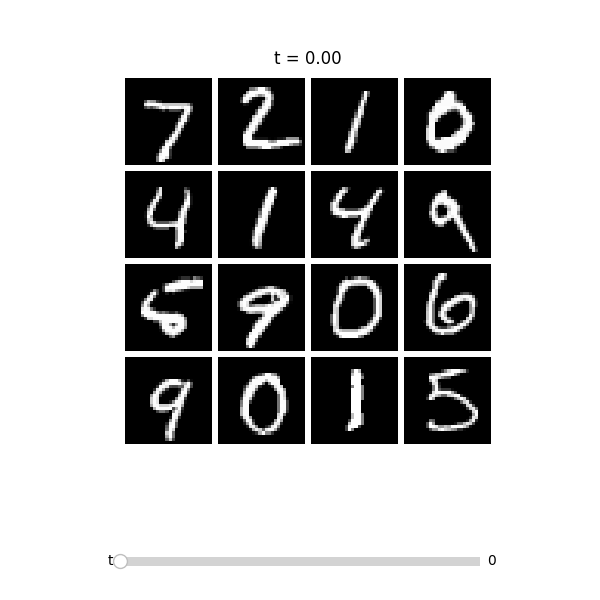

In [144]:
%matplotlib widget

import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from kac_utils_radial import create_sk, sample_trj

device = 'mps'#'cuda' if torch.cuda.is_available() else 'cpu'

# 1) Load 16 different MNIST test samples
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,)),
])
mnist_test = datasets.MNIST('./data', train=False, download=True, transform=transform)
# pick the first 16 (or random ones)
x0s = torch.stack([mnist_test[i][0].view(-1) for i in range(16)]).to(device)  # (16, 784)

# 2) Set your final time T and Kac params
T, a, c = 10.0, 25.0, 5.
print(np.sqrt(784))
# 3) Compute one τ per sample at time T
t = torch.full((16,), T, device=device)          # (16,)
s_k, sums = create_sk(a, t, T)                   # each of shape (16, max_jumps)
s_k, sums = s_k.to(device), sums.to(device)
  # (16,)
print(s_k.shape, sums.shape)
def compute_pos_multi(x0_batch, t_val):

    # 4) Use fixed random directions per sample
    u = torch.randn_like(x0s)
    u = u / u.norm(dim=1, keepdim=True)              # (16, 784)
    t = torch.full((B,), t_val, device=device)

    # 5) Apply forward‐Kac perturbation at T
    f   = 1.0 - t / T                                # fade‐out factor
    #f += torch.exp(-t)
    #f /= 2
    #f = torch.cos(0.5 * torch.pi * t / T)
    s = -2
    f = ((np.exp(2/s) * torch.cos(0.5*torch.pi * t / T)) / (np.exp(2/s) * torch.cos(0.5*torch.pi * t / T) + torch.sin(0.5*torch.pi * t / T)))
    xts = f.unsqueeze(1) * x0s                      # decay x0
    taus = sample_trj((1-f)*T, s_k, sums, a, T).to(device)
    print('shape:',u.shape)
    xts = xts + (c * taus).unsqueeze(1) * u 
    print(torch.var(xts))# (16, 784)
    print(torch.max(torch.abs(xts)))
    xts = xts.view(16, 1, 28, 28).cpu()              # (16,1,28,28)
    return xts

# ---------- initial plot ----------
fig, ax = plt.subplots(figsize=(6, 6))
plt.subplots_adjust(bottom=0.25)

pos0 = compute_pos_multi(x0s, 0.0).cpu()
grid  = make_grid(pos0, nrow=4, normalize=True, pad_value=1)
im    = ax.imshow(grid.permute(1,2,0).squeeze(), cmap="gray")
ax.axis("off")
ax.set_title(f"t = 0.00")

# ---------- slider ----------
ax_slider = fig.add_axes([0.2, 0.05, 0.6, 0.03])
slider     = Slider(ax_slider, "t", 0.0, T, valinit=0.0)

def update(val):
    t_now = slider.val
    #f = 1-t_now/T
    #f = np.exp(-t_now)
    pos   = compute_pos_multi(x0s, t_now).cpu()
    grid  = make_grid(pos, nrow=4, normalize=True, pad_value=1)
    im.set_data(grid.permute(1,2,0).squeeze())
    ax.set_title(f"t = {t_now:.2f},  " )
    fig.canvas.draw_idle()

slider.on_changed(update)
plt.show()



28.0
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

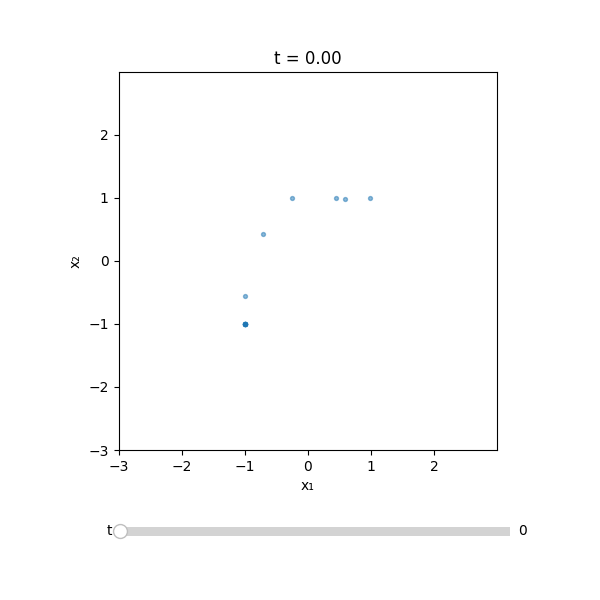

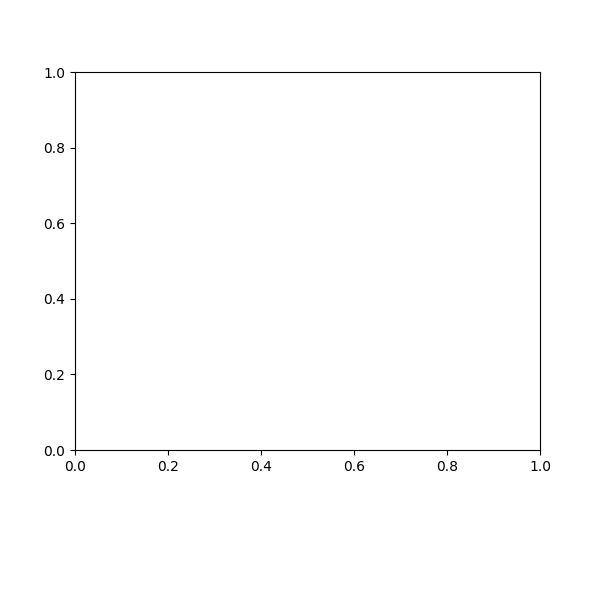

In [119]:
%matplotlib widget

import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from kac_utils_radial import create_sk, sample_trj

device = 'mps'#'cuda' if torch.cuda.is_available() else 'cpu'

# 1) Load 16 different MNIST test samples
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,)),
])
mnist_test = datasets.MNIST('./data', train=False, download=True, transform=transform)
batch_size = 500
# pick the first 16 (or random ones)
x0s = torch.stack([mnist_test[i][0].view(-1) for i in range(batch_size)]).to(device)  # (16, 784)

# 2) Set your final time T and Kac params
T, a, c = 10.0, 9.0, 3.
print(np.sqrt(784))
# 3) Compute one τ per sample at time T
t = torch.full((batch_size,), T, device=device)          # (16,)
s_k, sums = create_sk(a, t, T)                   # each of shape (16, max_jumps)
s_k, sums = s_k.to(device), sums.to(device)
  # (16,)

def compute_pos_multi(x0_batch, t_val):

    # 4) Use fixed random directions per sample
    u = torch.randn_like(x0s)
    u = u / u.norm(dim=1, keepdim=True)              # (16, 784)
    t = torch.full((batch_size,), t_val, device=device)

    # 5) Apply forward‐Kac perturbation at T
    #f   = 1.0 - t / T                                # fade‐out factor
    #f = torch.exp(-t)
    #f = torch.cos(0.5 * torch.pi * t / T)
    s = -2
    f = ((np.exp(2/s) * torch.cos(0.5*torch.pi * t / T)) / (np.exp(2/s) * torch.cos(0.5*torch.pi * t / T) + torch.sin(0.5*torch.pi * t / T)))
    xts = f.unsqueeze(1) * x0s                      # decay x0
    taus = sample_trj(t, s_k, sums, a, T).to(device)
    print(taus)
    xts = xts + (c * taus).unsqueeze(1) * u 
    print(torch.var(xts))# (16, 784)
    print(torch.max(torch.abs(xts)))
    xts = xts.view(batch_size, 1, 28, 28).cpu()              # (16,1,28,28)
    return xts

# ---------- initial plot ----------
fig, ax = plt.subplots(figsize=(6, 6))
plt.subplots_adjust(bottom=0.25)


pos0 = compute_pos_multi(x0, 0.0).cpu()
pos0 = pos0.reshape(16,-1)
# ------------------------------------
# Plot setup
fig, ax = plt.subplots(figsize=(6,6))
plt.subplots_adjust(bottom=0.25)

xp = 400
yp = 401
scatter = ax.scatter(pos0[:,xp], pos0[:,yp], s=8, alpha=0.5)
ax.set_aspect('equal')
margin = 2#c * T + 1.0
print(pos0.shape)
ax.set_xlim(pos0[:,xp].min()-margin, pos0[:,xp].max()+margin)
ax.set_ylim(pos0[:,yp].min()-margin, pos0[:,yp].max()+margin)
ax.set_xlabel('x₁'); ax.set_ylabel('x₂')
ax.set_title(f"t = 0.00")

# ------------------------------------
# Slider
ax_slider = plt.axes([0.2, 0.1, 0.65, 0.03])
slider = Slider(ax_slider, 't', 0.0, T, valinit=0.0)

def update(val):
    t_now = slider.val
    pos = compute_pos_multi(x0, t_now).cpu()
    pos = pos.reshape(16,-1)
    scatter.set_offsets(pos.cpu()[:, xp:yp+1].numpy())
    ax.set_title(f"t = {t_now:.2f}")
    fig.canvas.draw_idle()

slider.on_changed(update)
plt.show()




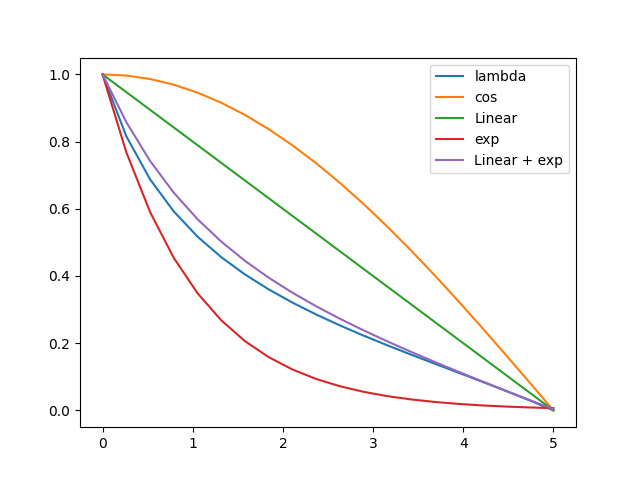

In [111]:
s = -2
T =5

t = torch.linspace(0,T,20)
f = ((np.exp(2/s) * torch.cos(0.5*torch.pi * t / T)) / (np.exp(2/s) * torch.cos(0.5*torch.pi * t / T) + torch.sin(0.5*torch.pi * t / T)))
f_lin= 1- t/T
f_exp = torch.exp(-t)
plt.figure()
plt.plot(t,f, label='lambda')
plt.plot(t,torch.cos(0.5*torch.pi*t/T), label='cos')
plt.plot(t,f_lin, label='Linear')
plt.plot(t, f_exp, label='exp')
plt.plot(t, (f_exp+f_lin)/2, label='Linear + exp')
plt.legend()

28.0
Var per-coordinate: 0.2827742099761963
Max abs entry: 1.6135441064834595


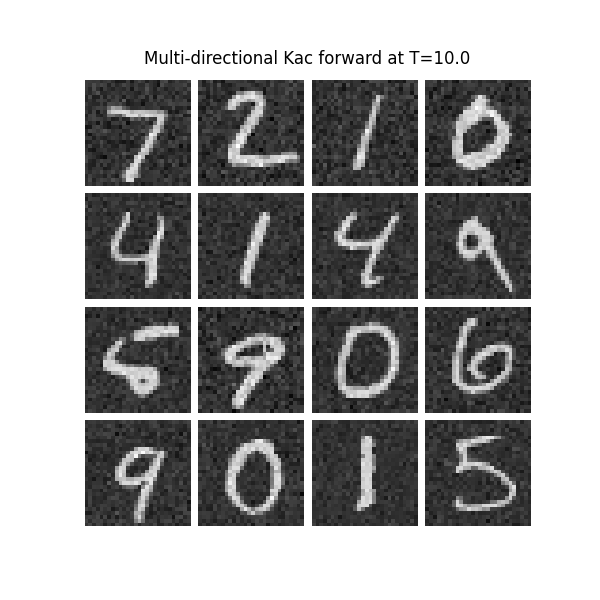

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from kac_utils_radial import create_sk, sample_trj

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1) Load 16 different MNIST test samples
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,)),
])
mnist_test = datasets.MNIST('./data', train=False, download=True, transform=transform)
# pick the first 16 (or random ones)
x0s = torch.stack([mnist_test[i][0].view(-1) for i in range(16)]).to(device)  # (16, 784)

# 2) Set your final time T and Kac params
T, a, c = 10.0, 1, 1
print(np.sqrt(784))
# 3) Compute one τ per sample at time T
t = torch.full((16,), T, device=device)          # (16,)
s_k, sums = create_sk(a, t, T)                   # each of shape (16, max_jumps)
s_k, sums = s_k.to(device), sums.to(device)
taus = sample_trj(t, s_k, sums, a, T).to(device)  # (16,)

# 4) Use fixed random directions per sample
u = torch.randn_like(x0s)
u = u / u.norm(dim=1, keepdim=True)              # (16, 784)

# 5) Apply forward‐Kac perturbation at T but re‐sample direction per jump
B, D = x0s.shape            # B=16, D=784
# s_k, sums from before: shape (B, J)
# Compute which segments actually contribute durations:
mask      = sums < t.unsqueeze(1)          # (B, J)
n_jumps   = mask.sum(dim=1)                # (B,)

# Build per-segment durations (full segments + one partial)
durations = s_k * mask.float()             # full segments
prev_idx   = (n_jumps - 1).clamp(min=0)     # index of last full
prev_cum   = sums.gather(1, prev_idx.unsqueeze(1)).squeeze(1)
prev_cum[n_jumps==0] = 0.0
partial    = (t - prev_cum).clamp(min=0)    # scalar remainder
durations.scatter_(1, n_jumps.unsqueeze(1), partial.unsqueeze(1))  # add partial

# Sample one new random unit-vector per segment
J = s_k.shape[1]
u_k = torch.randn(B, J, D, device=device)
u_k = u_k / u_k.norm(dim=2, keepdim=True)  # normalize each (B,J) vector

# Sum them up: x_T = x0 + c * Σ_k durations[b,k] * u_k[b,k]
xts = x0s + (c * durations.unsqueeze(2) * u_k).sum(dim=1)  # (B, D)

# (optional diagnostics)
print("Var per-coordinate:", xts.var(dim=0).mean().item())
print("Max abs entry:", xts.abs().max().item())

# Now reshape and plot as before
xts = xts.view(B, 1, 28, 28).cpu()
grid = make_grid(xts, nrow=4, normalize=True, pad_value=1)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1,2,0).squeeze(), cmap='gray')
plt.axis('off')
plt.title(f'Multi-directional Kac forward at T={T}')
plt.show()
